In [1]:
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import requests
import sqlite3
import time
import random
import io

def get_date_range_from_db(fname:str) -> Tuple[datetime.datetime, datetime.datetime]:
    def trans_str2datetime(str_date:str) -> datetime.datetime:
        date = datetime.datetime.strptime(str_date, '%Y-%m-%d %H:%M:%S').date()
        return date

    with sqlite3.connect(fname) as conn:
        c = conn.cursor()
        c.execute('SELECT MIN(日期), MAX(日期) FROM daily_price;')
        date_from, date_to = c.fetchone()
        date_from = trans_str2datetime(date_from)
        date_to   = trans_str2datetime(date_to)
        print(f'資料庫日期: {date_from} 到 {date_to}')
    return date_from, date_to

def remove_date_delimiters(date_time:datetime.datetime) -> str:
    return ''.join(str(date_time).split(' ')[0].split('-'))

def crawler(date_time:str) -> Dict:
    page_url = 'https://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date=' + date_time + '&type=ALLBUT0999'
    page = requests.get(page_url)
    use_text = page.text.splitlines()
    initital_point = ""
    for i, text in enumerate(use_text):
        if "證券代號" in text:
            initital_point = i
            break
            
    stock_df = pd.read_csv(io.StringIO(''.join([text[:-1] + '\n' for text in use_text[initital_point:]])))
    stock_df['證券代號'] = stock_df['證券代號'].apply(lambda x: x.replace('"', '').replace('=', ''))
    return stock_df

def prase_num_days(now_date:datetime.datetime, num_days:int) -> Dict:
    df_dict = {}
    for _ in range(num_days):
        try:
            time.sleep(random.uniform(2, 5))
            date_str = remove_date_delimiters(now_date)
            df = crawler(date_str)
            df_dict[date_str] = df
            print('successful', date_str)
        except Exception as e:
            print("error:", e)
        finally:
            now_date = now_date - datetime.timedelta(days=1)
    return df_dict

In [2]:
dbname = 'daily_price.db'
db_from, db_to = get_date_range_from_db(fname=dbname)
today = datetime.date.today()
missing_days = (today - db_to).days - 1
result_dict = prase_num_days(now_date=today, num_days=missing_days)

資料庫日期: 2010-06-18 到 2024-04-02


In [3]:
class Istock:
    def __init__(self, 
                 dates:List[str],
                 volumes:List[str], 
                 open_prices:List[str], 
                 high_prices:List[str], 
                 low_prices:List[str], 
                 close_prices:List[str]) -> None:        
        self._date        = dates
        self._volume      = volumes
        self._open_price  = open_prices
        self._high_price  = high_prices
        self._low_price   = low_prices
        self._close_price = close_prices
        
    @property
    def date(self) -> List[str]:
        return self._date
    
    @property
    def volume(self) -> List[str]:
        return self._volume
    
    @property
    def open_price(self) -> List[str]:
        return self._open_price
    
    @property
    def high_price(self) -> List[str]:
        return self._high_price
    
    @property
    def low_price(self) -> List[str]:
        return self._low_price
    
    @property
    def close_price(self) -> List[str]:
        return self._close_price
    
class Stock(Istock):
    def __init__(self, stock_id:str, dbname:str) -> None:
        self.stock_id    = stock_id
        self.stock_infos = self.fetch_data_from_db(dbname=dbname)
        super().__init__(dates=self._date, 
                         volumes=self._volume, 
                         open_prices=self._open_price, 
                         high_prices=self._high_price, 
                         low_prices=self._low_price, 
                         close_prices=self._close_price)

    def fetch_data_from_db(self, dbname:str):
        def trans_str2datetime(str_date:str) -> datetime.datetime:
            date = datetime.datetime.strptime(str_date, '%Y-%m-%d %H:%M:%S').date()
            return date
        with sqlite3.connect(dbname) as conn:
            stock_infos = pd.read_sql(con=conn,
                                      sql=f"SELECT 日期, 成交股數, 開盤價, 最高價, 最低價, 收盤價 FROM 'daily_price' WHERE 證券代號 = {self.stock_id} ORDER BY 日期 ASC")
            stock_infos
        if not stock_infos.empty:
            self._date        = stock_infos['日期'].tolist()
            self._volume      = stock_infos['成交股數'].tolist()
            self._open_price  = stock_infos['開盤價'].tolist()
            self._high_price  = stock_infos['最高價'].tolist()
            self._low_price   = stock_infos['最低價'].tolist()
            self._close_price = stock_infos['收盤價'].tolist()
        return stock_infos
    
    def moving_average(self, period:int) -> Dict:
        name = f"{period}_ma"
        self.stock_infos[name] = self.stock_infos['收盤價'].rolling(period).mean()
        
    def calculate_kd(self):
        # 計算 RSV
        self.stock_infos['min'] = self.stock_infos['最低價'].rolling(9).min()
        self.stock_infos['max'] = self.stock_infos['最高價'].rolling(9).max()
        self.stock_infos['rsv'] = (self.stock_infos['收盤價'] - self.stock_infos['min']) / (self.stock_infos['max'] - self.stock_infos['min'])
        self.stock_infos.dropna(inplace=True)
        # 計算 K
        K_list = [50]
        for rsv in self.stock_infos['rsv']:
            K_yestarday = K_list[-1]
            K_today = 2/3 * K_yestarday + 1/3 * rsv
            K_list.append(K_today)
        self.stock_infos['K'] = K_list[1:]

        # 計算 D
        D_list = [50]
        for k in self.stock_infos['K']:
            D_yestarday = D_list[-1]
            D_today = 2/3 * D_yestarday + 1/3 * k
            D_list.append(D_today)
        self.stock_infos['D'] = D_list[1:]
        

In [4]:
dbname = 'daily_price.db'
stock = Stock(stock_id="2330", dbname=dbname)
stock.calculate_kd()
stock.stock_infos.index = stock.stock_infos['日期'].apply(lambda x:x.split(' ')[0])
stock.stock_infos.drop('日期', axis=1, inplace=True)
stock.stock_infos

,成交股數,開盤價,最高價,最低價,收盤價,min,max,rsv,K,D
日期,,,,,,,,,,
2010-06-30,58319672,60.3,61.0,60.3,60.6,60.3,63.7,0.088235,33.362745,44.454248
2010-07-01,65215602,60.6,60.6,59.9,60.0,59.9,63.7,0.026316,22.250602,37.053033
2010-07-02,67300030,60.0,60.7,60.0,60.3,59.9,63.3,0.117647,14.872950,29.659672
2010-07-05,88484101,60.3,61.8,60.3,61.4,59.9,62.6,0.555556,10.100485,23.139943
2010-07-06,69857079,58.9,59.9,58.8,59.9,58.8,62.6,0.289474,6.830148,17.703345
...,...,...,...,...,...,...,...,...,...,...
2024-03-27,19732209,785.0,785.0,779.0,779.0,752.0,792.0,0.675000,0.706921,0.683093
2024-03-28,28393398,774.0,776.0,768.0,769.0,752.0,792.0,0.425000,0.612948,0.659711
2024-03-29,20212820,769.0,781.0,768.0,779.0,752.0,792.0,0.675000,0.633632,0.651018


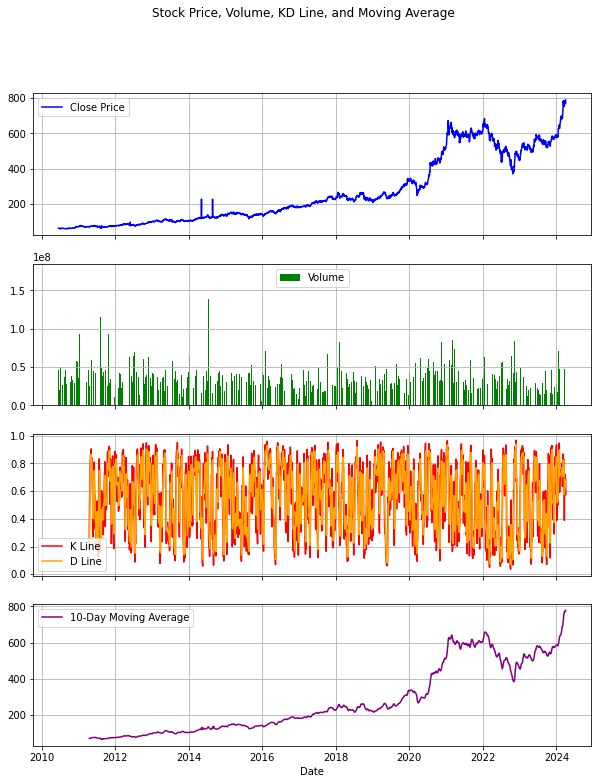

In [5]:
ma_period = 10
stock.moving_average(period=ma_period)
df_plot = stock.stock_infos[200:].copy()
ma_values = df_plot['10_ma']
k_values  = df_plot['K'] 
d_values  = df_plot['D']
# 設置日期格式
stock_dates = pd.to_datetime(stock.date)
# 設置子圖
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# 繪製股價
axs[0].plot(stock_dates, stock.close_price, label='Close Price', color='blue')
axs[0].legend()
axs[0].grid(True)

# 繪製成交量
axs[1].bar(stock_dates, stock.volume, label='Volume', color='green')
axs[1].legend()
axs[1].grid(True)

#繪製 KD 線
axs[2].plot(stock_dates[len(stock_dates)-len(k_values):], k_values, label='K Line', color='red')
axs[2].plot(stock_dates[len(stock_dates)-len(d_values):], d_values, label='D Line', color='orange')
axs[2].legend()
axs[2].grid(True)

# 繪製移動平均線
ma_values = list(ma_values)
axs[3].plot(stock_dates[len(stock_dates)-len(ma_values):], ma_values, label=f'{ma_period}-Day Moving Average', color='purple')
axs[3].legend()
axs[3].grid(True)

# 設置標題和標籤
plt.suptitle('Stock Price, Volume, KD Line, and Moving Average')
plt.xlabel('Date')
plt.show()

# Train Model

In [6]:
stock.stock_infos

,成交股數,開盤價,最高價,最低價,收盤價,min,max,rsv,K,D,10_ma
日期,,,,,,,,,,,
2010-06-30,58319672,60.3,61.0,60.3,60.6,60.3,63.7,0.088235,33.362745,44.454248,NaN
2010-07-01,65215602,60.6,60.6,59.9,60.0,59.9,63.7,0.026316,22.250602,37.053033,NaN
2010-07-02,67300030,60.0,60.7,60.0,60.3,59.9,63.3,0.117647,14.872950,29.659672,NaN
2010-07-05,88484101,60.3,61.8,60.3,61.4,59.9,62.6,0.555556,10.100485,23.139943,NaN
2010-07-06,69857079,58.9,59.9,58.8,59.9,58.8,62.6,0.289474,6.830148,17.703345,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27,19732209,785.0,785.0,779.0,779.0,752.0,792.0,0.675000,0.706921,0.683093,773.1
2024-03-28,28393398,774.0,776.0,768.0,769.0,752.0,792.0,0.425000,0.612948,0.659711,771.6
2024-03-29,20212820,769.0,781.0,768.0,779.0,752.0,792.0,0.675000,0.633632,0.651018,774.2


In [7]:
import numpy as np
import pandas as pd
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

stock_infos = stock.stock_infos
# 數據預處理 # TODO 使用多點特徵
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_infos[['開盤價', '最高價', '最低價', '收盤價']].values.reshape(-1, 1))
print(type(scaled_data), scaled_data.shape)

# 切分數據集
train_data = scaled_data[:int(len(scaled_data) * 0.8), :]
test_data = scaled_data[int(len(scaled_data) * 0.8):, :]

# 定義函數用於處理數據集
def create_dataset(dataset, time_step=1):
    X_data, Y_data = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X_data.append(a)
        Y_data.append(dataset[i + time_step, 0])
    return np.array(X_data), np.array(Y_data)

# 創建訓練集和測試集
time_step = 30
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
# 將數據集轉換成LSTM需要的格式
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape, X_test.shape)
# 定義LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])#mean_squared_error

# 訓練模型
model.fit(X_train, Y_train, epochs=1, batch_size=4)

# 儲存模型
# model.save('model_2303.h5')  # reates a HDF5 file 'model.h5'

# 使用模型進行預測
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

# 計算預測準確性
rmse = np.sqrt(np.mean(((test_predict - Y_test) ** 2)))
print('RMSE:', rmse)

# 計算上漲/下跌機率
test_direction = np.sign(test_predict[1:] - test_predict[:-1])
up_probability = np.mean(test_direction == 1)
down_probability = np.mean(test_direction == -1)
print('Up Probability:', up_probability)
print('Down Probability:', down_probability)


<class 'numpy.ndarray'> (13504, 1)
(10772, 30) (2670, 30) (10772,) (2670,)
(10772, 30, 1) (2670, 30, 1)
84/84 [==============================] - 1s 6ms/step
RMSE: 24.55169498882949
Up Probability: 0.49943799175721243
Down Probability: 0.5005620082427875
